## Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# !unzip /content/drive/MyDrive/Python_pet_project/DATA.zip

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import random
import tqdm
import tensorflow as tf
import tempfile
import requests
from io import BytesIO
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

In [4]:
path = '/content/DATA'
img_path = '/content/DATA/1812.png'

## Preprocessors

### Degrade image

In [5]:
def degrade_image(img: np.ndarray) -> np.ndarray:
    """
    Realistic random degradation with limited ops per patch
    """
    img = img.copy().astype(np.uint8)

    max_ops = random.randint(2, 4)
    ops_used = 0

    # --- JPEG compression ---
    if ops_used < max_ops and random.random() < 0.7:
        quality = random.randint(15, 40)
        _, enc = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
        img = cv2.imdecode(enc, cv2.IMREAD_COLOR)
        ops_used += 1

    # --- Gaussian blur ---
    if ops_used < max_ops and random.random() < 0.5:
        k = random.choice([7, 9, 11, 13])
        sigma = random.uniform(1.0, 3.0)
        img = cv2.GaussianBlur(img, (k, k), sigmaX=sigma)
        ops_used += 1

    # --- Motion blur (random direction) ---
    if ops_used < max_ops and random.random() < 0.4:
        k = random.randint(7, 15)
        angle = random.uniform(0, np.pi)
        kernel = np.zeros((k, k), np.float32)
        x0, y0 = k // 2, k // 2
        x1 = int(x0 + np.cos(angle) * (k // 2))
        y1 = int(y0 + np.sin(angle) * (k // 2))
        cv2.line(kernel, (x0, y0), (x1, y1), 1, thickness=1)
        kernel /= kernel.sum()
        img = cv2.filter2D(img, -1, kernel)
        ops_used += 1

    # --- Noise ---
    if ops_used < max_ops and random.random() < 0.6:
        noise_std = random.uniform(8, 20)
        noise = np.random.normal(0, noise_std, img.shape).astype(np.float32)
        img = img.astype(np.float32) + noise
        img = np.clip(img, 0, 255).astype(np.uint8)
        ops_used += 1

    # --- Brightness / contrast ---
    if ops_used < max_ops and random.random() < 0.5:
        alpha = random.uniform(0.75, 1.1)
        beta = random.uniform(-20, 10)
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
        ops_used += 1

    # --- Color distortions (HSV) ---
    if ops_used < max_ops and random.random() < 0.4:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
        hsv[..., 1] *= random.uniform(0.6, 1.4)
        hsv[..., 0] += random.uniform(-5, 5)
        img = cv2.cvtColor(np.clip(hsv, 0, 255).astype(np.uint8), cv2.COLOR_HSV2RGB)
        ops_used += 1

    return img


### Make patches

In [6]:
def extract_patches(img, patch_size=224, step=112):
    H, W, C = img.shape

    patches = []
    positions = []

    y_poss = list(range(0, H - patch_size + 1, step))
    if y_poss[-1] + patch_size < H:
        y_poss.append(H - patch_size)

    x_poss = list(range(0, W - patch_size + 1, step))
    if x_poss[-1] + patch_size < W:
        x_poss.append(W - patch_size)

    for y in y_poss:
        for x in x_poss:
            patches.append(img[y:y+patch_size, x:x+patch_size])
            positions.append((y, x))

    return np.array(patches), positions, H, W

In [7]:
def get_weight_map(patch_size, eps=0.05):
    w = np.hanning(patch_size)
    w = np.maximum(w, eps)
    w2d = np.outer(w, w)
    return w2d[..., None]

def merge_patches(patches, positions, H, W, patch_size):
    C = patches[0].shape[2]

    output = np.zeros((H, W, C), dtype=np.float32)   # <-- ВАЖНО
    weight = np.zeros((H, W, 1), dtype=np.float32)

    weight_map = get_weight_map(patch_size)

    for patch, (y, x) in zip(patches, positions):
        output[y:y+patch_size, x:x+patch_size] += patch * weight_map
        weight[y:y+patch_size, x:x+patch_size] += weight_map

    output /= np.maximum(weight, 1e-6)
    output = np.clip(output, 0, 255)

    return output.astype(np.uint8)

### Padding

In [8]:
def pad_to_square(img: np.ndarray, patch_size: int, pad_mode: str = "reflect"):
    """
    Делает изображение:
    - квадратным
    - размер кратен patch_size
    Возвращает padded_img и pad_info (для обратного удаления)
    """

    if img.ndim != 3:
        raise ValueError(f"Expected (H, W, C), got {img.shape}")

    h, w, c = img.shape

    # 1. Делаем квадрат
    side = max(h, w)

    # 2. Делаем кратным patch_size
    target = ((side + patch_size - 1) // patch_size) * patch_size

    pad_h = target - h
    pad_w = target - w

    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    padded = np.pad(
        img,
        ((top, bottom), (left, right), (0, 0)),
        mode=pad_mode
    )

    pad_info = {
        "top": top,
        "bottom": bottom,
        "left": left,
        "right": right,
        "orig_shape": (h, w)
    }

    return padded, pad_info

In [9]:
def unpad_image(img: np.ndarray, pad_info: dict):
    """
    Убирает padding и возвращает изображение
    к исходному размеру
    """

    top = pad_info["top"]
    bottom = pad_info["bottom"]
    left = pad_info["left"]
    right = pad_info["right"]

    h, w = pad_info["orig_shape"]

    return img[
        top : top + h,
        left : left + w
    ]


### Batch generator

In [10]:
IMG_SIZE = 224
STEP = IMG_SIZE // 2
BATCH_SIZE = 48
AUTOTUNE = tf.data.AUTOTUNE

all_paths = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png'))]

random.shuffle(all_paths)
split = int(0.8 * len(all_paths))
train_paths = all_paths[:split]
val_paths = all_paths[split:]

paths = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png'))]


# ==========================
#   Train patch_generator  =
# ==========================


# -------------------------
# Patch generator (train)
# -------------------------
def patch_generator(paths, patch_size=224, step=112, max_patches_per_image=24, min_var=5.0):
    for path in random.sample(paths, len(paths)):  # shuffle files every epoch
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img, _ = pad_to_square(img, patch_size=patch_size)

        patches, _, _, _ = extract_patches(img, patch_size=patch_size, step=step)
        idxs = list(range(len(patches)))
        random.shuffle(idxs)

        count = 0
        for i in idxs:
            patch = patches[i]
            if patch.std() < min_var:
                continue

            y = patch.astype(np.float32) / 127.5 - 1.0

            if random.random() < 0.15:  # identity mapping
                x = patch.copy()
            else:
                x = degrade_image(patch)

            x = np.clip(x, 0, 255).astype(np.float32)
            x = x / 127.5 - 1.0

            yield x, y
            count += 1
            if count >= max_patches_per_image:
                break


train_dataset = tf.data.Dataset.from_generator(
    lambda: patch_generator(train_paths),
    output_signature=(
        tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32),
        tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32)
    )
)

train_dataset = (
    train_dataset
    .shuffle(2000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


# ==========================
#   Test patch_generator  =
# ==========================


# -------------------------
# Validation generator
# -------------------------
def val_patch_generator(paths, patch_size=224, step=112):
    for path in paths:  # order fixed
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img, _ = pad_to_square(img, patch_size=patch_size)

        patches, _, _, _ = extract_patches(img, patch_size=patch_size, step=step)

        for patch in patches:
            y = patch.astype(np.float32) / 127.5 - 1.0
            x = patch.copy()  # **фиксированная деградация**
            yield x, y


val_dataset = tf.data.Dataset.from_generator(
    lambda: val_patch_generator(val_paths),
    output_signature=(
        tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32),
        tf.TensorSpec((IMG_SIZE, IMG_SIZE, 3), tf.float32)
    )
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

## Predict

In [11]:
def predict_img(model, img_src):
    if isinstance(img_src, str): # if img_src is path
        img = cv2.imread(img_src)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = img_src.copy() # if img_src is np.array

    img, pad_info = pad_to_square(img, patch_size=IMG_SIZE)
    patches, pos, H, W = extract_patches(img, patch_size=IMG_SIZE, step=STEP)

    X = []
    for patch in patches:
        x = patch.astype(np.float32) / 127.5 - 1.0
        X.append(x)
    X = np.array(X)

    preds = model.predict(X)

    preds = (preds + 1.0) * 127.5
    preds = preds.astype(np.uint8)

    img_out = merge_patches(preds, pos, H, W, patch_size=IMG_SIZE)
    img_out = unpad_image(img_out, pad_info)

    return img_out

In [12]:
def show_before_after(model, img_source):
    """
    Показывает оригинальное и улучшенное изображение.
    Работает с локальным файлом или URL.
    """
    # ====================
    #   Uploading        =
    # ====================
    if img_source.startswith("http://") or img_source.startswith("https://"):
        response = requests.get(img_source)
        img_pil = Image.open(BytesIO(response.content)).convert("RGB")

        # Save for predict_img
        with tempfile.NamedTemporaryFile(suffix=".png") as tmp:
            img_pil.save(tmp.name)
            pred_img = predict_img(model, tmp.name)
        orig = np.array(img_pil)
    else:
        orig = cv2.imread(img_source)
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
        pred_img = predict_img(model, img_source)

    # ====================
    #   Vizualization    =
    # ====================
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(orig)
    plt.title("Original image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_img)
    plt.title("Enhanced image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## Model Building

In [13]:
# ====================
#   INPUT            =
# ====================
inp = Input(shape=(224, 224, 3), name='input_image')

# ====================
#   ENCODER          =
# ====================
# skip 1
x = Conv2D(16, 3, activation='relu', padding='same', name='enc1-conv1')(inp)
x = Conv2D(16, 3, activation='relu', padding='same', name='enc1-conv2')(x)
x = Dropout(0.2)(x)
skip1 = x
x = MaxPool2D(2, name='enc1-pool')(x)

# skip 2
x = Conv2D(32, 3, activation='relu', padding='same', name='enc2-conv1')(x)
x = Conv2D(32, 3, activation='relu', padding='same', name='enc2-conv2')(x)
x = Dropout(0.3)(x)
skip2 = x
x = MaxPool2D(2, name='enc2-pool')(x)

# skip 3
x = Conv2D(64, 3, activation='relu', padding='same', name='enc3-conv1')(x)
x = Conv2D(64, 3, activation='relu', padding='same', name='enc3-conv2')(x)
x = Dropout(0.4)(x)
skip3 = x
x = MaxPool2D(2, name='enc3-pool')(x)

# skip 4
x = Conv2D(128, 3, activation='relu', padding='same', name='enc4-conv1')(x)
x = Conv2D(128, 3, activation='relu', padding='same', name='enc4-conv2')(x)
x = Dropout(0.5)(x)
skip4 = x
x = MaxPool2D(2, name='enc4-pool')(x)

# skip 5
x = Conv2D(256, 3, activation='relu', padding='same', name='enc5-conv1')(x)
x = Conv2D(256, 3, activation='relu', padding='same', name='enc5-conv2')(x)
x = Dropout(0.2)(x)
skip5 = x
x = MaxPool2D(2, name='enc5-pool')(x)

# ====================
#   BOTTLENECK       =
# ====================
x = Conv2D(512, 3, activation='relu', padding='same', name='botn-conv1')(x)
x = Conv2D(512, 3, activation='relu', padding='same', name='botn-conv2')(x)
x = Dropout(0.5)(x)
botn = x

# ====================
#   DECODER          =
# ====================
# up 1
x = UpSampling2D(2, name='dec1-up')(botn)
x = Concatenate(name='concat1')([x, skip5])
x = Conv2D(256, 3, activation='relu', padding='same', name='dec1-conv1')(x)
x = Conv2D(256, 3, activation='relu', padding='same', name='dec1-conv2')(x)
x = Dropout(0.5)(x)

# up 2
x = UpSampling2D(2, name='dec2-up')(x)
x = Concatenate(name='concat2')([x, skip4])
x = Conv2D(128, 3, activation='relu', padding='same', name='dec2-conv1')(x)
x = Conv2D(128, 3, activation='relu', padding='same', name='dec2-conv2')(x)
x = Dropout(0.4)(x)

# up 3
x = UpSampling2D(2, name='dec3-up')(x)
x = Concatenate(name='concat3')([x, skip3])
x = Conv2D(64, 3, activation='relu', padding='same', name='dec3-conv1')(x)
x = Conv2D(64, 3, activation='relu', padding='same', name='dec3-conv2')(x)
x = Dropout(0.3)(x)

# up 4
x = UpSampling2D(2, name='dec4-up')(x)
x = Concatenate(name='concat4')([x, skip2])
x = Conv2D(32, 3, activation='relu', padding='same', name='dec4-conv1')(x)
x = Conv2D(32, 3, activation='relu', padding='same', name='dec4-conv2')(x)
x = Dropout(0.2)(x)

# up 5
x = UpSampling2D(2, name='dec5-up')(x)
x = Concatenate(name='concat5')([x, skip1])
x = Conv2D(16, 3, activation='relu', padding='same', name='dec5-conv1')(x)
x = Conv2D(16, 3, activation='relu', padding='same', name='dec5-conv2')(x)
x = Dropout(0.2)(x)

# ====================
#   OUTPUT           =
# ====================
outputs = Conv2D(3, 1, activation='tanh', padding='same', name='output')(x)

# ====================
#   MODEL            =
# ====================
model = tf.keras.Model(inputs=inp, outputs=outputs, name='UNet_5level_16start')

# model.summary()

In [14]:
# --- Compile model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mae',
    metrics=['mae', 'mse']
)

his = model.fit(train_dataset,
          epochs=20,
          validation_data=val_dataset)

Epoch 1/20
    771/Unknown 395s 428ms/step - loss: 0.2193 - mae: 0.2193 - mse: 0.0934

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


771/771 ━━━━━━━━━━━━━━━━━━━━ 433s 478ms/step - loss: 0.2192 - mae: 0.2192 - mse: 0.0933 - val_loss: 1.1114 - val_mae: 1.1114 - val_mse: 1.5260
Epoch 2/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 329s 412ms/step - loss: 0.1338 - mae: 0.1338 - mse: 0.0359 - val_loss: 1.0952 - val_mae: 1.0952 - val_mse: 1.4933
Epoch 3/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 328s 412ms/step - loss: 0.1255 - mae: 0.1255 - mse: 0.0318 - val_loss: 1.0651 - val_mae: 1.0651 - val_mse: 1.4325
Epoch 4/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 330s 414ms/step - loss: 0.1225 - mae: 0.1225 - mse: 0.0305 - val_loss: 1.0716 - val_mae: 1.0716 - val_mse: 1.4459
Epoch 5/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 336s 422ms/step - loss: 0.1205 - mae: 0.1205 - mse: 0.0298 - val_loss: 1.0408 - val_mae: 1.0408 - val_mse: 1.3852
Epoch 6/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 327s 410ms/step - loss: 0.1191 - mae: 0.1191 - mse: 0.0292 - val_loss: 1.0063 - val_mae: 1.0063 - val_mse: 1.3159
Epoch 7/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 326s 408ms/step - loss: 0.1161 - mae: 0.1161 - 

KeyboardInterrupt: 

In [2]:
# del model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


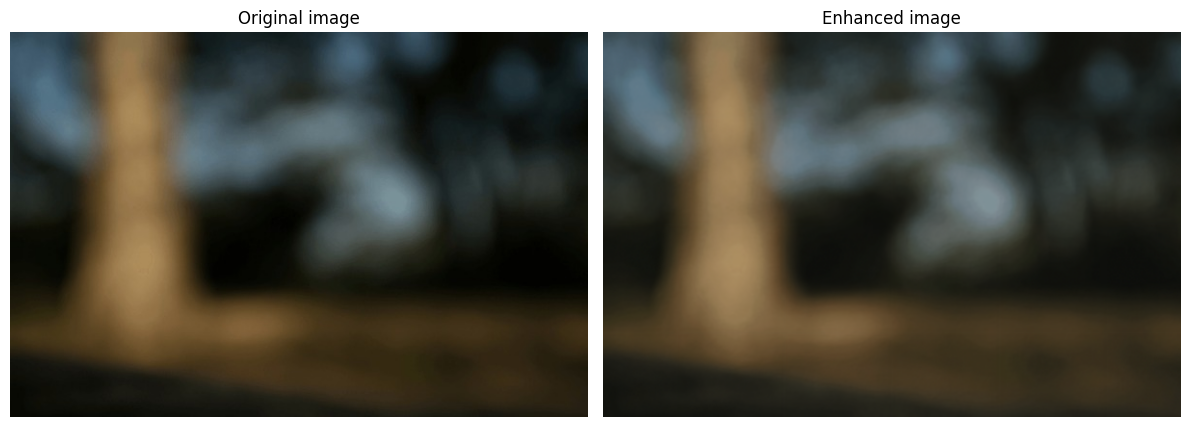

In [18]:
src = 'https://www.shutterstock.com/image-photo/nature-pictures-blurry-background-600nw-2377496305.jpg'
show_before_after(model, src)

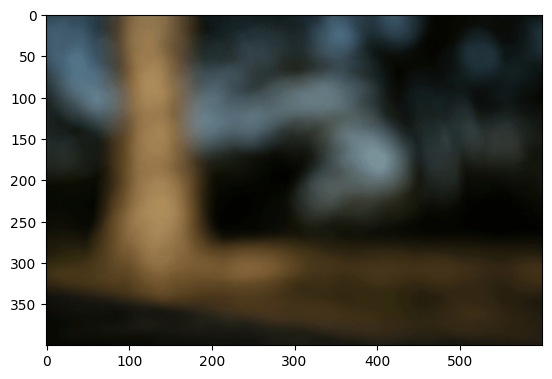

In [20]:
url = "https://www.shutterstock.com/image-photo/nature-pictures-blurry-background-600nw-2377496305.jpg"

response = requests.get(url)
img_pil = Image.open(BytesIO(response.content)).convert("RGB")

img_np = np.array(img_pil)

# print(img_np)
plt.imshow(img_np)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


array([[[60, 78, 87],
        [60, 78, 87],
        [59, 77, 85],
        ...,
        [26, 32, 30],
        [26, 33, 31],
        [26, 33, 32]],

       [[59, 78, 86],
        [59, 77, 86],
        [58, 76, 85],
        ...,
        [26, 33, 30],
        [27, 34, 32],
        [27, 34, 32]],

       [[59, 77, 86],
        [59, 77, 86],
        [58, 77, 86],
        ...,
        [27, 34, 32],
        [28, 35, 33],
        [27, 35, 33]],

       ...,

       [[19, 20, 15],
        [18, 20, 15],
        [19, 20, 15],
        ...,
        [43, 39, 28],
        [43, 39, 27],
        [44, 38, 28]],

       [[19, 20, 15],
        [19, 20, 15],
        [19, 20, 15],
        ...,
        [42, 37, 27],
        [42, 38, 27],
        [42, 38, 27]],

       [[18, 19, 15],
        [19, 19, 15],
        [19, 20, 15],
        ...,
        [41, 36, 26],
        [41, 37, 26],
        [40, 36, 26]]], dtype=uint8)
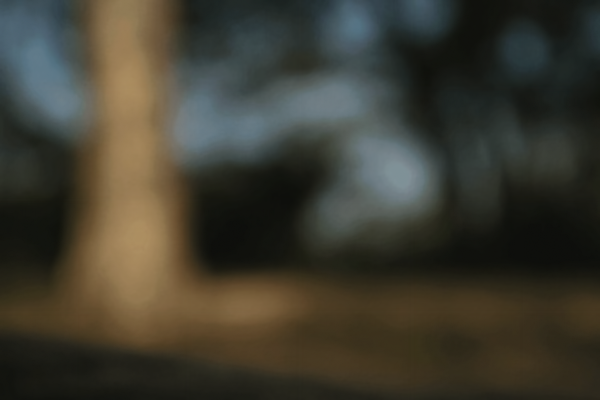

In [21]:
predict_img(model, img_np)

array([[[129, 144, 149],
        [135, 150, 155],
        [135, 150, 155],
        ...,
        [138, 146, 149],
        [138, 146, 149],
        [138, 146, 149]],

       [[129, 144, 149],
        [135, 150, 155],
        [135, 150, 155],
        ...,
        [138, 146, 149],
        [138, 146, 149],
        [138, 146, 149]],

       [[130, 145, 150],
        [135, 150, 155],
        [136, 151, 156],
        ...,
        [138, 146, 149],
        [138, 146, 149],
        [138, 146, 149]],

       ...,

       [[104, 108,  73],
        [106, 110,  75],
        [100, 104,  69],
        ...,
        [160, 165, 161],
        [162, 168, 164],
        [163, 169, 165]],

       [[105, 109,  74],
        [110, 114,  79],
        [104, 108,  73],
        ...,
        [168, 174, 174],
        [170, 176, 174],
        [171, 177, 177]],

       [[104, 108,  73],
        [112, 116,  81],
        [107, 111,  76],
        ...,
        [167, 172, 175],
        [168, 177, 176],
        [168, 176, 178]]], dtype=uint8)
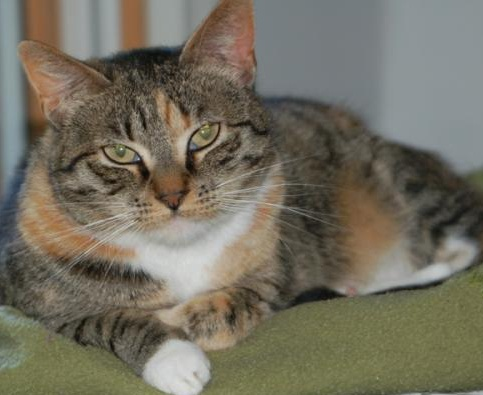

In [25]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img

array([[[138, 151, 149],
        [140, 153, 151],
        [141, 154, 152],
        ...,
        [135, 148, 146],
        [135, 148, 146],
        [135, 148, 146]],

       [[138, 151, 149],
        [140, 153, 151],
        [141, 154, 152],
        ...,
        [135, 148, 146],
        [135, 148, 146],
        [135, 148, 146]],

       [[138, 151, 149],
        [140, 153, 151],
        [141, 154, 152],
        ...,
        [135, 148, 146],
        [135, 148, 146],
        [135, 148, 146]],

       ...,

       [[110, 111,  72],
        [110, 111,  72],
        [110, 111,  72],
        ...,
        [175, 178, 170],
        [174, 176, 169],
        [172, 175, 167]],

       [[109, 110,  71],
        [109, 110,  71],
        [109, 110,  71],
        ...,
        [170, 173, 164],
        [164, 167, 159],
        [163, 166, 157]],

       [[108, 109,  70],
        [108, 109,  70],
        [108, 109,  70],
        ...,
        [156, 160, 149],
        [156, 159, 148],
        [150, 153, 142]]], dtype=uint8)
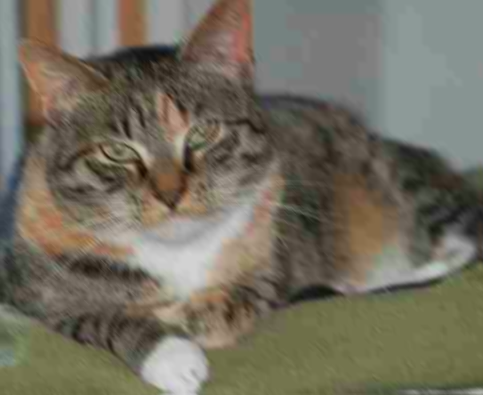

In [26]:
img = degrade_image(img)
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


array([[[141, 154, 148],
        [142, 155, 149],
        [144, 156, 151],
        ...,
        [137, 150, 145],
        [137, 150, 145],
        [137, 150, 144]],

       [[141, 153, 147],
        [142, 155, 149],
        [144, 157, 151],
        ...,
        [137, 150, 145],
        [137, 150, 145],
        [137, 150, 145]],

       [[141, 154, 148],
        [142, 155, 149],
        [144, 157, 151],
        ...,
        [137, 150, 145],
        [137, 150, 145],
        [137, 150, 145]],

       ...,

       [[115, 111,  77],
        [115, 111,  76],
        [115, 111,  77],
        ...,
        [178, 181, 169],
        [177, 180, 168],
        [176, 179, 167]],

       [[114, 110,  76],
        [115, 110,  76],
        [115, 110,  76],
        ...,
        [170, 175, 164],
        [168, 172, 162],
        [167, 172, 161]],

       [[114, 109,  76],
        [114, 109,  75],
        [114, 109,  75],
        ...,
        [161, 165, 156],
        [158, 161, 152],
        [156, 160, 151]]], dtype=uint8)
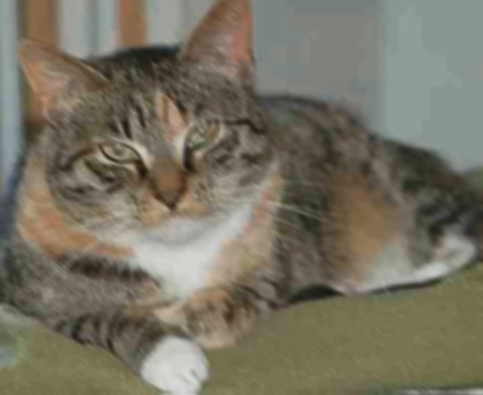

In [29]:
img_p = predict_img(model, img)
img_p

In [28]:
def norm(img):
    return img.astype(np.float32) / 127.5 - 1.0

def psnr(y_true, y_pred):
    return tf.image.psnr(norm(y_true), norm(y_pred), max_val=2.0)  # [-1,1]

psnr(img, img_p)

<tf.Tensor: shape=(), dtype=float32, numpy=34.69293975830078>

In [ ]:
checkpoint_cb = ModelCheckpoint(
    "best_model.h5",       # путь к файлу, куда сохраняем
    monitor="val_loss",    # метрика, по которой выбираем лучший момент
    save_best_only=True,   # сохраняем только, если валид. loss улучшился
    save_weights_only=True # можно True, чтобы сохранять только веса
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,                 # можно больше
    callbacks=[checkpoint_cb, earlystop_cb]
)

model.load_weights("best_model.h5")

In [30]:
model.save('model.h5')

In [ ]:
model = tf.keras.models.load_model('model.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)